# Higgs Boson Activity Analysis

Analysis of the Twitter activity during the Higgs boson announcement (July 2012), based on the [SNAP Higgs Twitter Dataset](https://snap.stanford.edu/data/higgs-twitter.html).

## Data

The original dataset (`higgs-activity_time.txt`) can be downloaded from the SNAP repository.  
Each row has the format:
```
userA  userB  timestamp  interaction
```
where `interaction` is one of `MT` (mention), `RT` (retweet), or `RE` (reply).

> **Running without the original data:** A synthetic sample file with the same structure is provided at `data/sample-activity_time.txt`. It is generated by `data/generate_sample.py` and mimics the temporal patterns of the real dataset using entirely synthetic user IDs and timestamps.
> 
> To use the real dataset, set `data_file` in the *Load Data* cell to the path of your local copy.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from statsmodels.tsa.stattools import acf
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os
from matplotlib.patches import Rectangle

plt.rcParams.update({
    'font.size': 15,
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'mathtext.rm': 'serif',
})

In [2]:
# Read the data
data_file = os.path.join(
    os.path.dirname(os.path.abspath("__file__")),
    "data", "sample-activity_time.txt"
)

df = pd.read_csv(data_file, sep=r'\s+', header=None, names=['userA', 'userB', 'timestamp', 'interaction'])

# Convert Unix timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

user_activity = df.groupby('userA')['datetime'].agg(['min', 'max']).rename(
    columns={'min': 'start', 'max': 'end'}
).reset_index()

user_activity['end'] = user_activity.apply(
    lambda row: row['end'] if row['start'] != row['end'] else row['start'] + pd.Timedelta(hours=1),
    axis=1
)

df0 = df.copy()


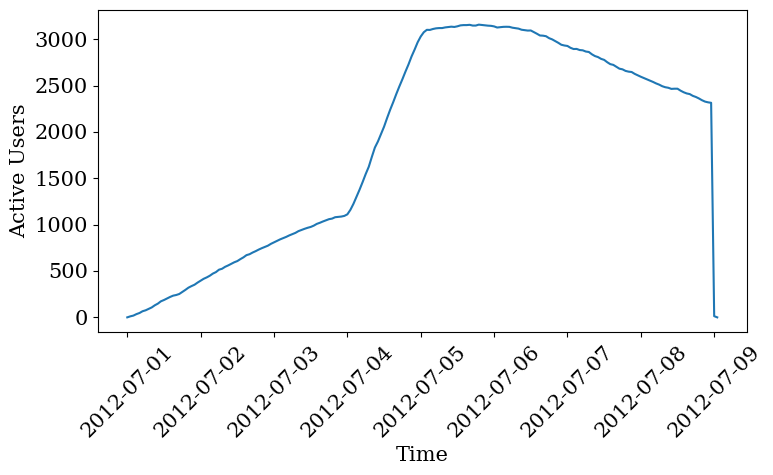

In [3]:
start_time = user_activity['start'].min().floor('h')
end_time = user_activity['end'].max().ceil('h')


time_index = pd.date_range(start=start_time, end=end_time, freq='h')

start_bins = np.searchsorted(time_index, user_activity['start'])
end_bins = np.searchsorted(time_index, user_activity['end'], side='right')

diff = np.zeros(len(time_index) + 1, dtype=np.int32)
np.add.at(diff, start_bins, 1)
np.add.at(diff, end_bins, -1)

active_counts = pd.Series(np.cumsum(diff)[:-1], index=time_index)

plt.figure(figsize=(8, 5))
plt.plot(active_counts.index, active_counts.values)
plt.xlabel('Time')
plt.ylabel('Active Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

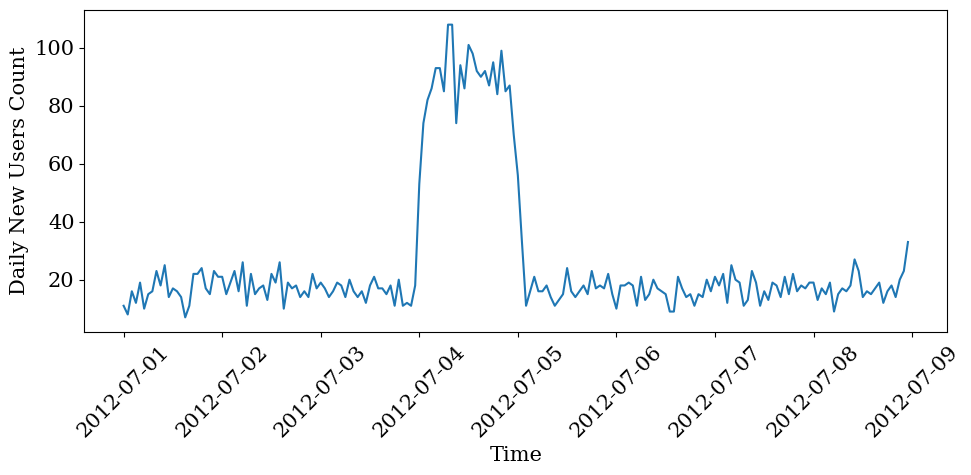

In [4]:
user_activity['first_hour'] = user_activity['start'].dt.floor('h')

daily_new_users = user_activity.groupby('first_hour').size()

plt.figure(figsize=(10, 5))
plt.plot(daily_new_users.index, daily_new_users.values)
plt.xlabel('Time')
plt.ylabel('Daily New Users Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

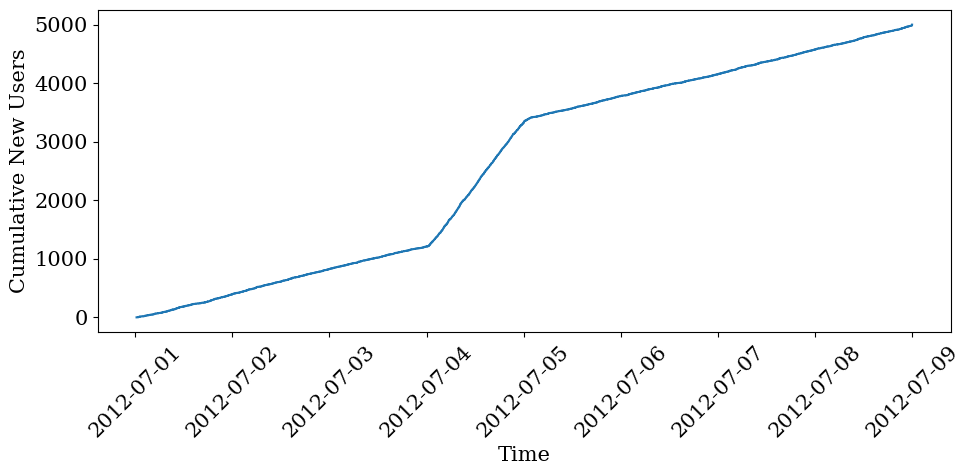

In [5]:
user_activity_sorted = user_activity.sort_values('start')

cumulative_new_users = range(1, len(user_activity_sorted) + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.step(user_activity_sorted['start'], cumulative_new_users, where='post')
plt.xlabel('Time')
plt.ylabel('Cumulative New Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
comparison_date = pd.Timestamp("2012-07-04")

before_count = daily_new_users[daily_new_users.index < comparison_date].sum()

after_count = daily_new_users[daily_new_users.index >= comparison_date].sum()

print("New users before {}: {}".format(comparison_date.date(), before_count))
print("New users from {} onward: {}".format(comparison_date.date(), after_count))

New users before 2012-07-04: 1210
New users from 2012-07-04 onward: 3790


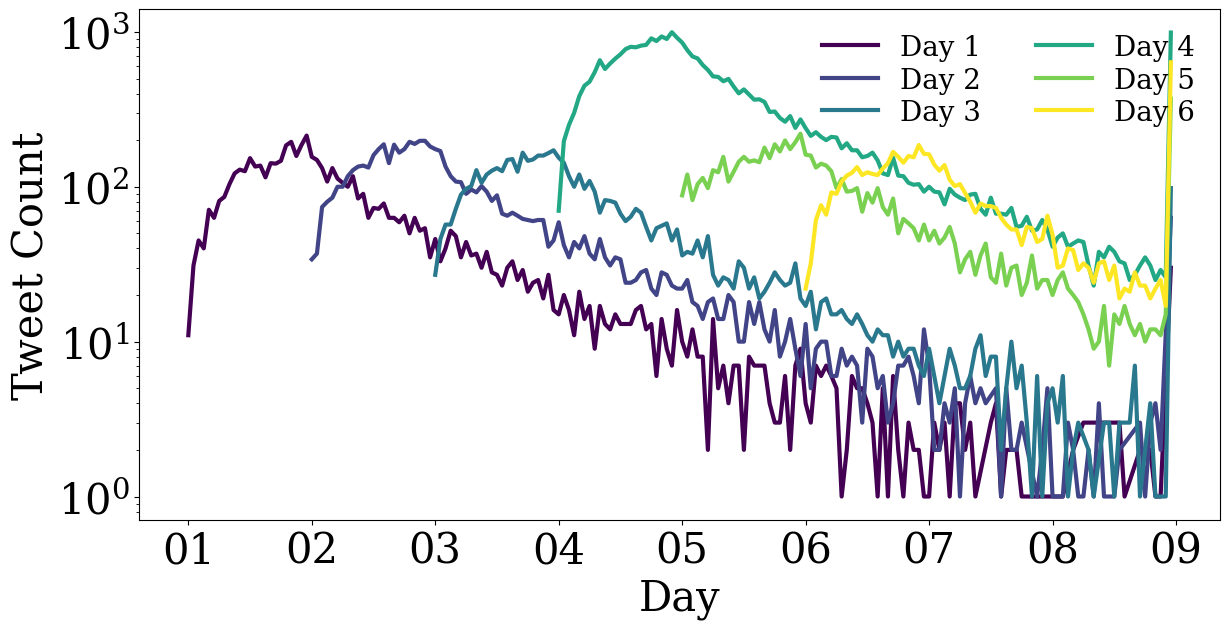

In [7]:
plt.rcParams.update({
    'font.size': 30,
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'mathtext.rm': 'serif',
})

cohort_date = pd.Timestamp("2012-07-01")
n_cohorts = 6

cohort_series = []
for day in range(n_cohorts):
    cohort_users = user_activity[
        user_activity['start'].dt.floor('D') == cohort_date + pd.Timedelta(days=day)
    ]['userA'].unique()
    df_cohort = df0[df0['userA'].isin(cohort_users)]
    ts = df_cohort.groupby(df_cohort['datetime'].dt.floor('h')).size()
    cohort_series.append(ts)

activity_ts = cohort_series[0]

cmap = plt.get_cmap('viridis', n_cohorts)
fig, ax = plt.subplots(figsize=(13, 7))
for i, ts in enumerate(cohort_series):
    ax.plot(ts.index, ts.values, label=f'Day {i+1}', color=cmap(i), lw=3)

ax.set_xlabel('Day')
ax.set_ylabel('Tweet Count')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.legend(frameon=False, loc='upper right', fontsize=20, ncol=2, labelspacing=0.2)
plt.tight_layout()
plt.show()

daily_activity_ts = df0[df0['userA'].isin(cohort_series[0].index)].groupby(
    df0['datetime'].dt.floor('D')
).size()

Detected rupture points (indices): [0, 75, 95, 192]


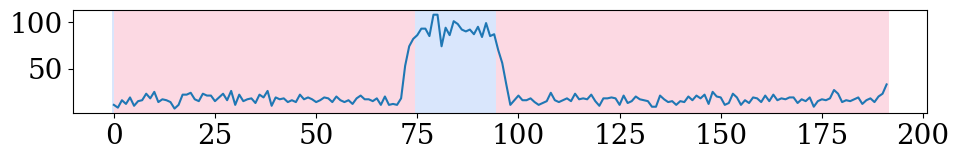

In [8]:
plt.rcParams.update({
    'font.size': 20,  
})

signal = daily_new_users.values

algo = rpt.Pelt(model="rbf").fit(signal)
change_points = algo.predict(pen=5) # 15, 30 min = 25, 1h = 10, 5

change_points = [0] + change_points
print("Detected rupture points (indices):", change_points)

rpt.display(signal, change_points)
plt.show()

In [9]:

frequencies, periods, period_errors = [], [], []
frequencies_autocorr, periods_autocorr, periods_autocorr_errors = [], [], []

for brk_i in range(len(change_points) - 1):
    start = change_points[brk_i]
    end = change_points[brk_i + 1]
    segment = signal[start:end]

    x_vals_hours = np.arange(len(segment), dtype=float)  # 1 sample = 1 hour
    N = len(segment)
    delta = 1.0  # hours per sample
    freq_resolution = 1 / (N * delta)

    autocorr = acf(segment, nlags=N - 1)

    fft_vals = np.fft.fft(segment)
    fft_freq = np.fft.fftfreq(N, d=delta)
    pos_mask = fft_freq > 0
    fft_freq_pos = fft_freq[pos_mask]
    power = np.abs(fft_vals[pos_mask]) ** 2
    dominant_freq = fft_freq_pos[np.argmax(power)]

    if dominant_freq > 0:
        period = 1 / dominant_freq
        period_error = freq_resolution / (dominant_freq ** 2)
    else:
        period, period_error = np.nan, np.nan
    frequencies.append(dominant_freq)
    periods.append(period)
    period_errors.append(period_error)

    fft_vals_autocorr = np.fft.fft(autocorr)
    freq_autocorr = np.fft.fftfreq(len(autocorr), d=delta)
    pos_mask_ac = freq_autocorr > 0
    freq_autocorr_pos = freq_autocorr[pos_mask_ac]
    power_pos = np.abs(fft_vals_autocorr[pos_mask_ac]) ** 2
    dominant_freq_autocorr = freq_autocorr_pos[np.argmax(power_pos)]

    if dominant_freq_autocorr > 0:
        period_autocorr = 1 / dominant_freq_autocorr
        period_autocorr_error = freq_resolution / (dominant_freq_autocorr ** 2)
    else:
        period_autocorr, period_autocorr_error = np.nan, np.nan
    frequencies_autocorr.append(dominant_freq_autocorr)
    periods_autocorr.append(period_autocorr)
    periods_autocorr_errors.append(period_autocorr_error)

print("Periods (h):", [f"{p:.1f}" if not np.isnan(p) else "nan" for p in periods])
print("Periods ACF (h):", [f"{p:.1f}" if not np.isnan(p) else "nan" for p in periods_autocorr])

Periods (h): ['10.7', '2.5', '16.2']
Periods ACF (h): ['10.7', '2.5', '16.2']


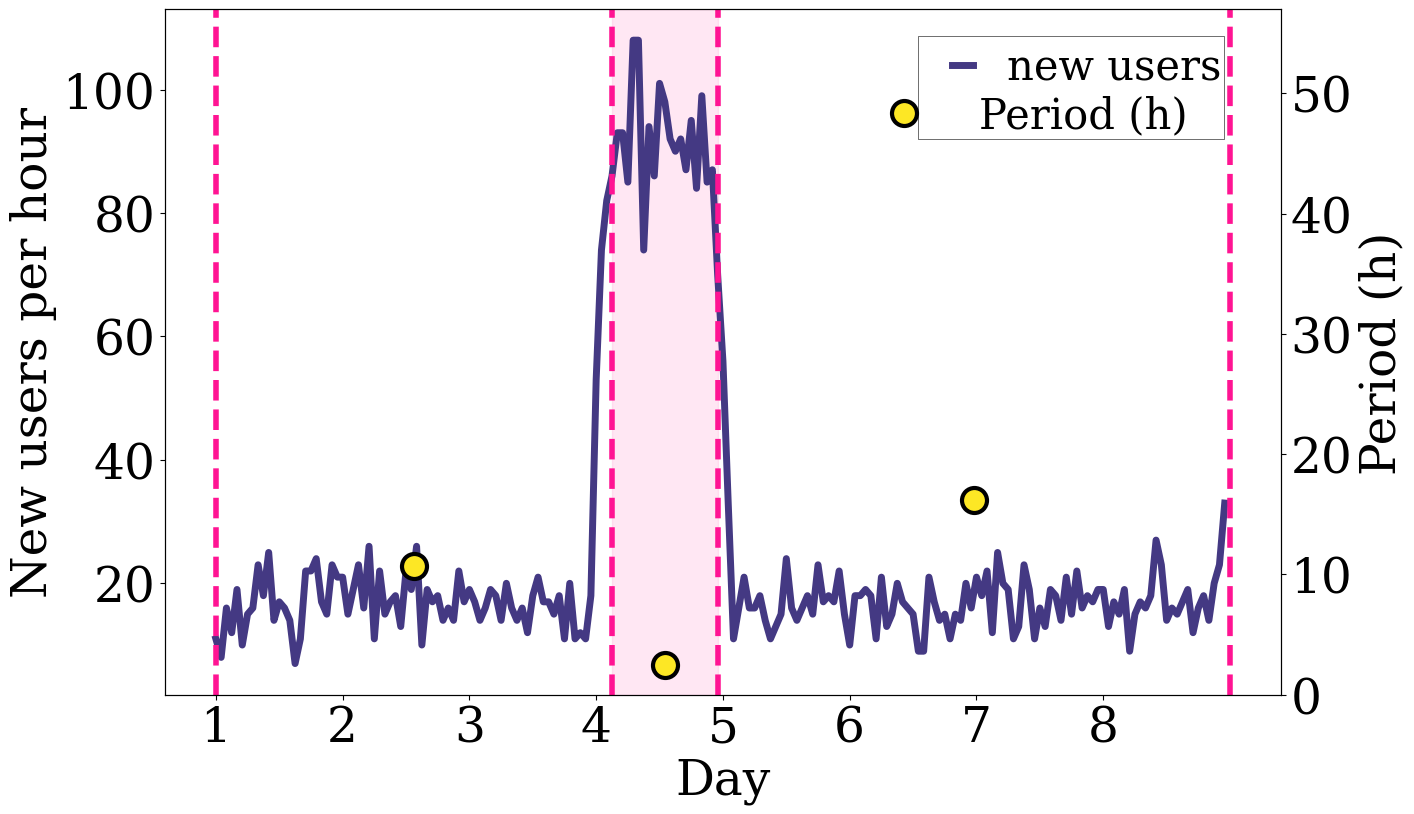

In [10]:


plt.rcParams.update({
    'font.size': 35,
})

yellow = "#fde725"
green = "#35b779"

fig, ax = plt.subplots(figsize=(15, 9))
ax1 = ax.twinx()

ax.plot(signal, label='new users', color="#443983", linewidth=5)

for i in range(len(change_points) - 1):
    start = change_points[i]
    end = change_points[i + 1]
    if i == 1 or i == 3:
        ax.axvspan(start, end, color='deeppink', alpha=0.1)
    ax.axvline(start, color='deeppink', linestyle='--', linewidth=4)
ax.axvline(change_points[-1], color='deeppink', linestyle='--', linewidth=4)

handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(),
          frameon=False, loc='upper right', bbox_to_anchor=(0.98, 1), fontsize=30, handlelength=0.5)
ax.set_xlabel("Day")
ax.set_ylabel("New users per hour")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x / 24) + 1))
ax.set_xticks(np.arange(0, 24 * 8, 24))

x_vals_segments = np.array([(change_points[i] + change_points[i + 1]) / 2
                             for i in range(len(change_points) - 1)])
ax1.plot(x_vals_segments, periods_autocorr, marker='o', markeredgecolor='black',
         color=yellow, label='Period (h)', linewidth=0, markersize=18, markeredgewidth=3)
ax1.set_ylabel('Period (h)')
ax1.set_ylim(0, 57)
ax1.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.95, 0.93), fontsize=30, labelspacing=0.2)

legend_bg = Rectangle((0.675, 0.81), 0.274, 0.15, transform=ax.transAxes,
                       facecolor='white', edgecolor='black', ls='-', lw=0.4, zorder=5, clip_on=False)
ax.add_patch(legend_bg)

plt.tight_layout()
plt.show()